Questions:
1. In Python (or Pandas) write a code to import the transaction table

answer: df = pd.read_excel('ModelingDataSet.xlsx')

2 a) Use your favorite classification model to segment the extended costs (Explain your code)

answer: Basic idea is to use use mean value to do the clustering. For details, please see the "build model" parts for details. I also tried use variance to differentiatethe margin, but it is not good, so I deleted that part. 

b) Show your solution when the number of bins (nb_b) from 3 to 10 and measure the accuracy of
your proposed solution with the following descriptive statistics for each bin: the average margin
%, the coefficient of variation of the margin %

answer: the differences of average margin cross bins are big

Please see the "Results part"

c) What column in the Transaction table could help you to differentiate the margins even better?

answer: Square of Margin% may help.

In [1]:
from matplotlib import pyplot as plt
import scipy.stats as ss
import numpy as np
import pandas as pd
from IPython.display import display

In [2]:
df = pd.read_excel('ModelingDataSet.xlsx')

## Apply summary statistics

In [4]:
display(df.head())
print df.shape


,Transaction_ID,Unit_cost,Quantity,Extended_cost,Revenue,Margin%
0,1,0.261167,1200,313.40,468.00,0.330341
1,2,1.073075,400,429.23,572.00,0.249597
2,3,0.109778,2880,316.16,662.88,0.523050
3,4,0.007200,24000,172.80,288.00,0.400000
4,5,0.012630,10000,126.30,320.00,0.605312


(28103, 6)


In [5]:
display(df.describe(include='all'))

,Transaction_ID,Unit_cost,Quantity,Extended_cost,Revenue,Margin%
count,28103.000000,28103.000000,28103.000000,28103.000000,28103.000000,28103.000000
mean,14052.000000,0.210462,5556.689820,276.245760,381.811127,0.411105
std,8112.781644,0.473328,16631.417435,622.663652,790.691345,0.217018
min,1.000000,0.000008,5.000000,0.020000,4.890000,0.091326
25%,7026.500000,0.025100,200.000000,22.500000,57.750000,0.178685
50%,14052.000000,0.109778,1150.000000,86.400000,150.000000,0.443076
75%,21077.500000,0.249111,5000.000000,310.650000,427.200000,0.610069
max,28103.000000,45.849321,600000.000000,21634.120000,28938.000000,0.999927


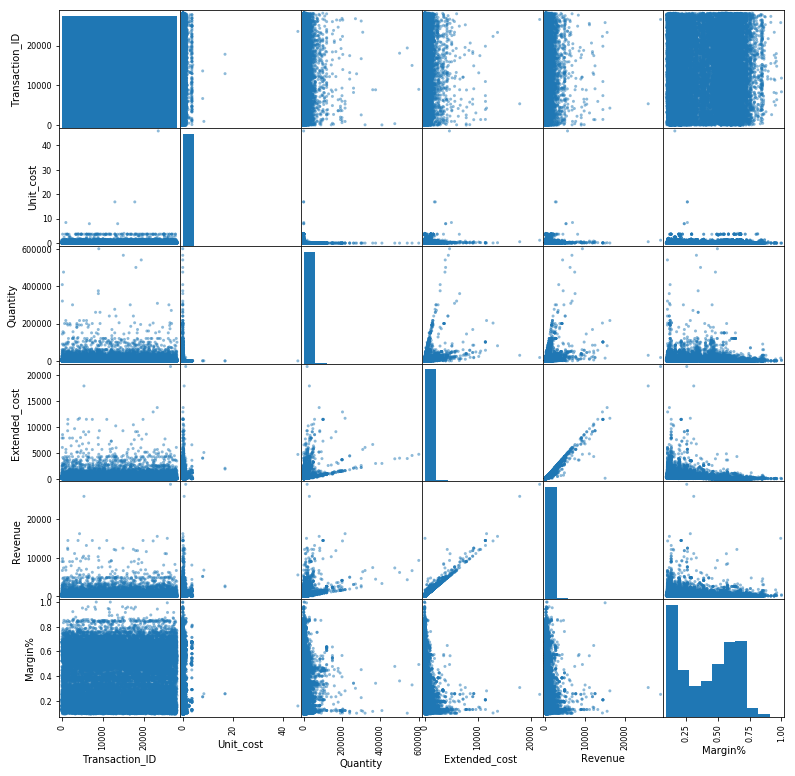

In [98]:
#check feature-feature relationship
pd.plotting.scatter_matrix(df, alpha=0.5, figsize=(13, 13))
plt.show()

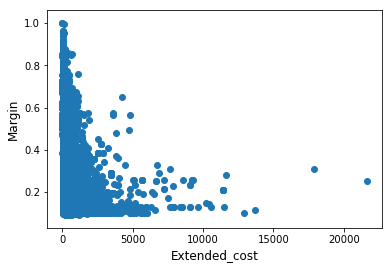

In [6]:
plt.scatter(df['Extended_cost '], df['Margin%'])
plt.xlabel('Extended_cost', fontsize=12)
plt.ylabel('Margin', fontsize=12)

plt.show()

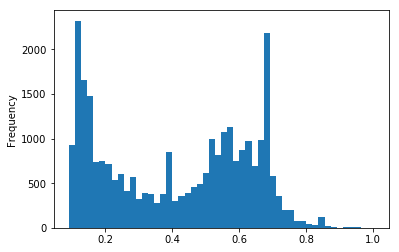

In [7]:
df['Margin%'].plot.hist(bins=50)
plt.show()

Check data distribution. Most data have extended cost less than 5000usd. 
It seems there are two peaks in the Margin histogram. The first one is margin  below 0.2, the other one has margin range from 0.4 to 0.8  

In [8]:
df_sort_cost=df.sort_values(by=['Extended_cost '])
display (df_sort_cost.head()) 

,Transaction_ID,Unit_cost,Quantity,Extended_cost,Revenue,Margin%
8400,8401,0.000008,2500,0.02,276.25,0.999927
11833,11834,0.000010,4000,0.04,442.00,0.999909
19774,19775,0.166667,18,3.00,4.89,0.386503
13010,13011,0.038800,100,3.88,11.97,0.675856
4772,4773,0.038800,100,3.88,11.97,0.675856


## Other measures of variability

In [89]:
df.var() #check the variance

Transaction_ID    6.581723e+07
Unit_cost         2.240391e-01
Quantity          2.766040e+08
Extended_cost     3.877100e+05
Revenue           6.251928e+05
Margin%           4.709700e-02
dtype: float64

In [91]:
ss.variation(df) #check the coefficient of variation

array([ 0.57732973,  2.24895846,  2.9929908 ,  2.25398056,  2.0708597 ,
        0.52788079])

## Build model

According to the question requirement, we should cluster the data with the minimum variance within each (extended cost) bin and the maximum average margin difference across (extended cost) bins, so we should find suitable clustering criteria. We may fit a gaussian distribution for each bin and to compare the mean and variance of each bin. However for the limited time, I decide to use mean of margin of each bin to do the clustering. 

Classical clustering model can't sovle this problem, because they will create bin with overlapping extended cost.

First, calculate mean of margin at the smallest bin. Because the question required clustering on extended cost, so the smallest bin is each single extended cost[1]. To do this, sort and group data by extended cost, and calculate the mean. Then scan the whole data and calculate differences of mean of margin between two neighbor data, find the closest neighbor data, merge them to a new bin. Repeat this procedure until we get required number of bins.

Merge bins with close mean of margin can make merged bin with minimum variance. 
The difference across bins can be measured with variance of mean of each bin. 
Variance=E[x^2]-E[x]^2, because E[x]^2 is same, we can maximize E[x^2]. x1^2+x2^2>[(x1+x2)/2]^2, the closer between x1 and x2, the slower the decrese of E[x^2]. So we can get maximum difference across bins after merge if we merge bins with closet mean value. 

[1] Note, the extended cost bin requirement is not very clear. I am not sure if the question requires round number. For example, there are two extended cost 0.02 and 0.04, if round number required, they will be treated as same cost -- 1 usd. In my model, I use actual number, so they are in two different bins at very begining. These two situations both work in my model. It just need a small change in the first step.     

In [3]:
# First, calculate mean for each extended cost
cost_group=df.groupby(['Extended_cost ']).mean()

In [4]:
#display(cost_group.describe())
display(cost_group.head())

,Transaction_ID,Unit_cost,Quantity,Revenue,Margin%
Extended_cost,,,,,
0.02,8401.000000,0.000008,2500.0,276.250000,0.999927
0.04,11834.000000,0.000010,4000.0,442.000000,0.999909
3.00,19775.000000,0.166667,18.0,4.890000,0.386503
3.88,12768.684211,0.038800,100.0,12.163684,0.679868
4.84,11787.250000,0.019360,250.0,13.837500,0.633857


In [5]:
print cost_group.shape

(6682, 5)


In [6]:
#mean of margin at each extended cost (smallesr bin). this is will be the model starting point and input
x=np.array(cost_group['Margin%'])
print x[0:5]
print len(x)

[ 0.999927    0.999909    0.386503    0.67986758  0.63385725]
6682


In [7]:
#prepare a index list storing information of bin index and extended cost range of this bin
#bin index will be used to calculate mean after merge 
#for example, [3, 21, 3.88, 3.88] means there are 19 points in this bin, and the extended cost is 3.88
def cost_indexf():
    group_size=df.groupby(['Extended_cost '],as_index=False).size() # get group size for grouped data
    cnt=np.array(group_size) #write group size to array


    #arr_index stores information of bin boudaries and extended cost range of this bin     
    cost_index=[[]]
    cost_index[0]=[0,0,0.02,0.02]
    for i in xrange(1,cost_group.shape[0]):
        cost_in_group=float(format(group_size.index[i], '.2f')) # extended cost for each group
        cost_index.append([cost_index[i-1][1]+1,cost_index[i-1][1]+cnt[i],cost_in_group,cost_in_group ])
    return cost_index
    #print cost_index[:10]
    #print len(cost_index)

In [8]:
def merge_close(a,arr_index,nb_b): # a is the input array. arr_index, nb_b is number of bins
    #indcopy=arr_index
    while len(a)>nb_b:
        minp=np.argmin(abs(np.diff(a)))      # find index of closet differences between neighbor data
        k1=arr_index[minp][1]-arr_index[minp][0]+1     # calculate number of data in the first to be merged bin
        k2=arr_index[minp+1][1]-arr_index[minp+1][0]+1  # calculate number of data in the second to be merged bin 
        a[minp]=(k1*a[minp]+k2*a[minp+1])/(k1+k2) #replace first bin with new merged mean value 
        
        # update index information
        arr_index[minp]=[arr_index[minp][0],arr_index[minp+1][1],arr_index[minp][2],arr_index[minp+1][3]]  
        
        del arr_index[minp+1]    #delete one index after merge
        a=np.delete(a, [minp+1]) #delete one bin after merge
    return a, arr_index    # return mean of merged bins, return index and extended cost range for each bin


## Results

In [9]:
for i in xrange(3,11):
    cost_index=cost_indexf()
    results,ind = merge_close(x,cost_index,i)
    print
    print "Results for ",i,"bins:"
    for cost in ind:
        print "Extended_cost", cost[2:],"\t","Number","\t", cost[1]-cost[0]+1
        print ("Aver. margin"+"\t"+"\t"+"coefficient of variation")
        print df["Margin%"][(df["Extended_cost "]>=cost[2]) & (df["Extended_cost "]<=cost[3])].mean(),"\t","\t",ss.variation(df["Margin%"][(df["Extended_cost "]>=cost[2]) & (df["Extended_cost "]<=cost[3])])



Results for  3 bins:
Extended_cost [0.02, 0.04] 	Number 	2
Aver. margin		coefficient of variation
0.999918 		9.0007380605e-06
Extended_cost [3.0, 4269.48] 	Number 	28004
Aver. margin		coefficient of variation
0.411870693044 		0.526507435322
Extended_cost [4371.66, 21634.12] 	Number 	97
Aver. margin		coefficient of variation
0.177980298969 		0.457868897374

Results for  4 bins:
Extended_cost [0.02, 0.04] 	Number 	2
Aver. margin		coefficient of variation
0.999918 		9.0007380605e-06
Extended_cost [3.0, 4254.84] 	Number 	28003
Aver. margin		coefficient of variation
0.411862254508 		0.526516460227
Extended_cost [4269.48, 4269.48] 	Number 	1
Aver. margin		coefficient of variation
0.648175 		0.0
Extended_cost [4371.66, 21634.12] 	Number 	97
Aver. margin		coefficient of variation
0.177980298969 		0.457868897374

Results for  5 bins:
Extended_cost [0.02, 0.04] 	Number 	2
Aver. margin		coefficient of variation
0.999918 		9.0007380605e-06
Extended_cost [3.0, 1138.07] 	Number 	26809
Aver. margin	

most data were clustered to the bin of extended cost range 3-900, with average margin of 0.43 and coefficient of variation 0.5. We can see the differences across bins are big.